In [1]:
%load_ext autoreload
%autoreload 2


In [2]:

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
from suite3d import nbtools as nbui

In [5]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS003',
    'date' :          '2024-08-16',
    'expnum' :         [1,2,3,4]}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21])[n.array([6,7,8,9,10,11,12])],
    # number of files to use for the initial pass
    'n_init_files' :   3,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 7,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : False,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
}


job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str + 'subset', tifs = tifs[:20],
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset already exists
Loading job directory for SS003_2024-08-16_1-2-3-4subset in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param gpu_reg
   Updated main params file


In [6]:
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [7]:
# %%time
# job.run_init_pass()

In [8]:
img3d = job.load_summary()['ref_img_3d']

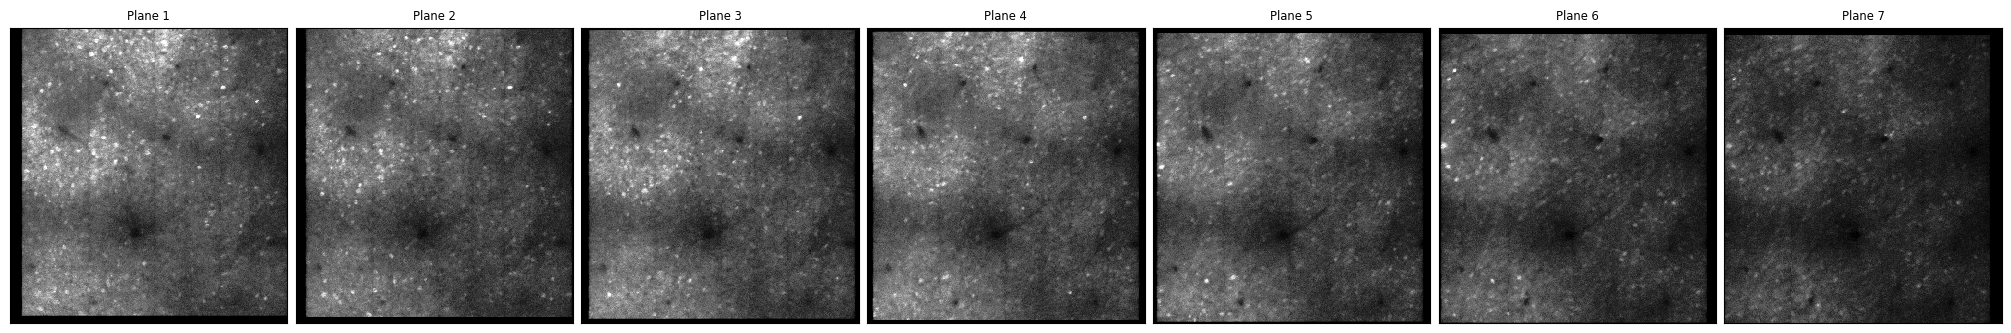

In [9]:
tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5),vminmax=(100,5000))

In [10]:
# tfu.show_tif_all_planes(data.mean(axis=1), ncols=7, figsize=(20,5),vminmax=(100,5000))

In [11]:
# tfu.show_tif_all_planes(img3d, ncols=7, figsize=(20,5),vminmax=(100,5000))

In [12]:
# %%time
# job.register(tifs=job.tifs)

In [13]:
mov = job.get_registered_movie()

In [14]:
reg = job.load_registration_results()

In [41]:
from importlib import reload
from suite3d import extension as ext

In [150]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0 # original run with 0.1
job.params['standard_vmap'] = True
corr_map_new = job.calculate_corr_map(iter_limit=10)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 616, 579
      Running batch 1 of 10
         Timer prep completed in 1.082 sec
         Timer batch_setup completed in 0.468 sec
         Timer batch_edgecrop completed in 0.041 sec
         Timer accum_meanmeax completed in 0.388 sec
         Timer batch_rolling_mean_filt completed in 0.369 sec
         Timer batch_accum_sdmov completed in 1.142 sec
         Timer batch_norm_sdmov completed in 0.189 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 1.485 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d comple

In [210]:

corr_map_new_thresh = ext.thresh_mask_corr_map(corr_map_new, thresh_window_size_pix = 51, corrmap_thresh_pct = 65)

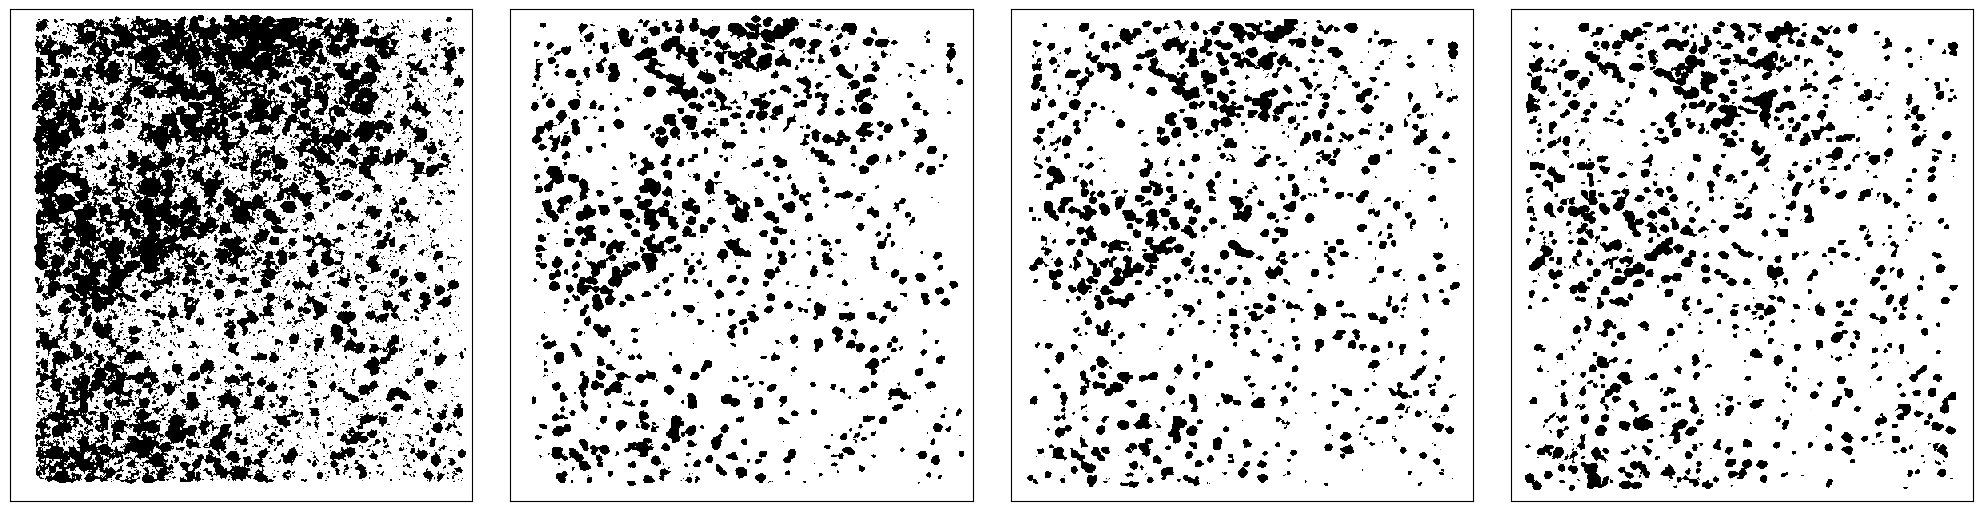

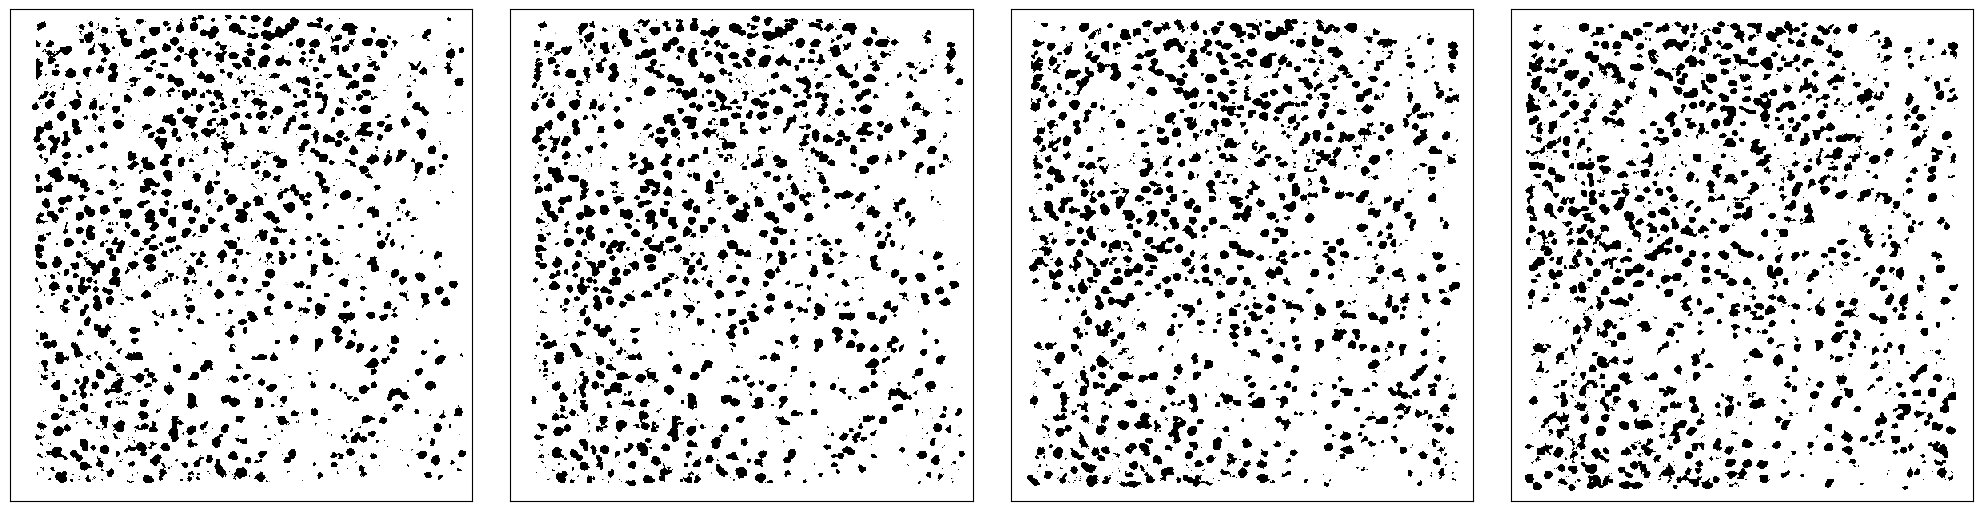

In [214]:
f,axs = tfu.show_tif_all_planes(corr_map_new[:4], ncols=4, figsize=(20,5), vminmax=(0.195, 0.195+1e-3), cmap='Greys')
for ax in axs[0]: ax.set_title('')
f,axs = tfu.show_tif_all_planes(corr_map_new_thresh[:4], ncols=4, figsize=(20,5), vminmax=(0.02, 0.02+1e-3), cmap='Greys')
for ax in axs[0]: ax.set_title('')

In [185]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 1.0
job.params['intensity_thresh'] = 0.1 # original run with 0.1
job.params['standard_vmap'] = True
corr_map_new_exp1 = job.calculate_corr_map(iter_limit=10)
corr_map_new_thresh_exp1 = ext.thresh_mask_corr_map(corr_map_new_exp1, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 616, 579
      Running batch 1 of 10
         Timer prep completed in 1.055 sec
         Timer batch_setup completed in 0.468 sec
         Timer batch_edgecrop completed in 0.041 sec
         Timer accum_meanmeax completed in 0.389 sec
         Timer batch_rolling_mean_filt completed in 0.373 sec
         Timer batch_accum_sdmov completed in 1.144 sec
         Timer batch_norm_sdmov completed in 0.189 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 1.534 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d comple

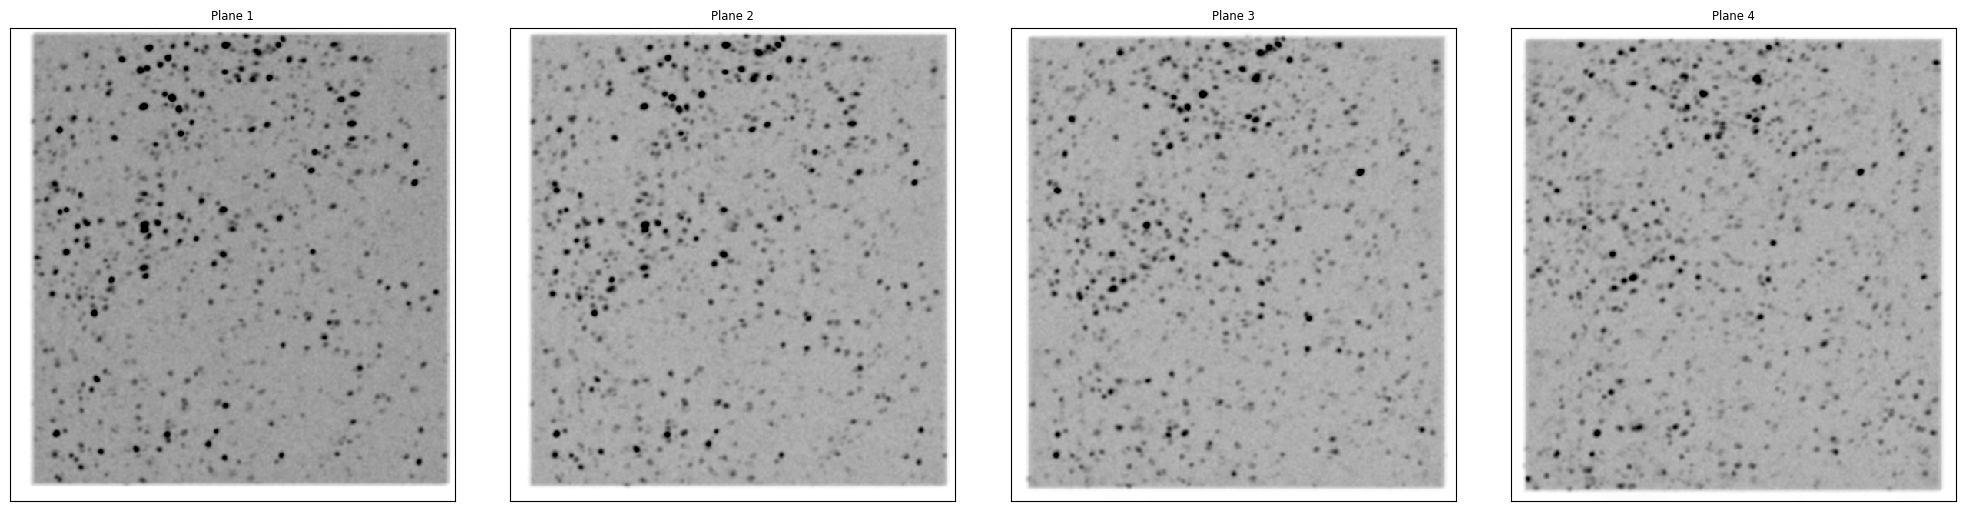

In [187]:

tfu.show_tif_all_planes(corr_map_new_exp1[:4], ncols=4, figsize=(20,5), vminmax=(0.00, 0.2), cmap='Greys')

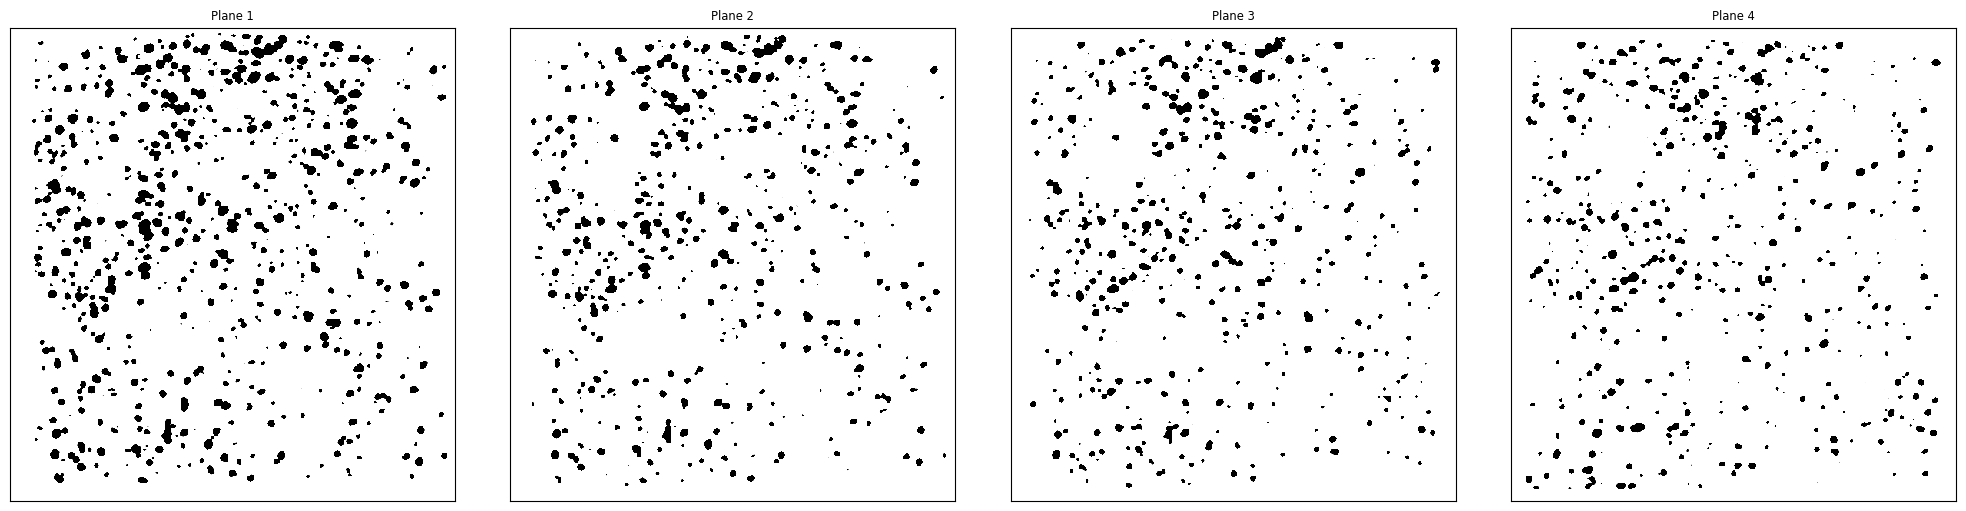

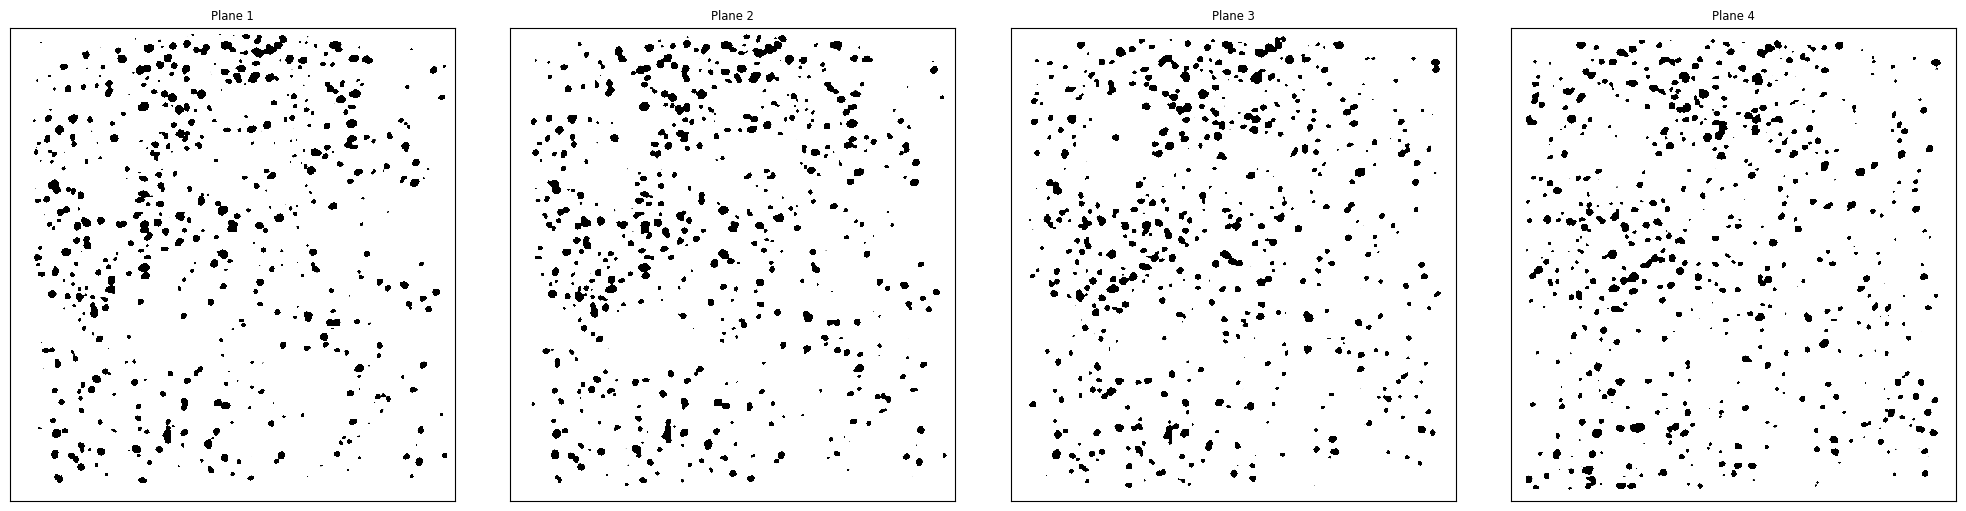

In [191]:
tfu.show_tif_all_planes(corr_map_new_exp1[:4], ncols=4, figsize=(20,5), vminmax=(0.11, 0.11+1e-3), cmap='Greys')
tfu.show_tif_all_planes(corr_map_new_thresh_exp1[:4], ncols=4, figsize=(20,5), vminmax=(0.02, 0.02+1e-3), cmap='Greys')

In [55]:
%%time
job.params['voxel_size_um'] = (20, 2.5, 2.5)
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200

job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0 # original run with 0.1
job.params['standard_vmap'] = True
corr_map = job.calculate_corr_map(iter_limit=10)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/corrmap
   Updated main params file
   Computing correlation map of movie with 2000 frames, volume shape: 7, 616, 579
      Running batch 1 of 10
         Timer prep completed in 1.065 sec
         Timer batch_setup completed in 0.470 sec
         Timer batch_edgecrop completed in 0.041 sec
         Timer accum_meanmeax completed in 0.396 sec
         Timer batch_rolling_mean_filt completed in 0.379 sec
         Timer batch_accum_sdmov completed in 1.157 sec
         Timer batch_norm_sdmov completed in 0.192 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 1.488 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d comple

In [71]:
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 90)

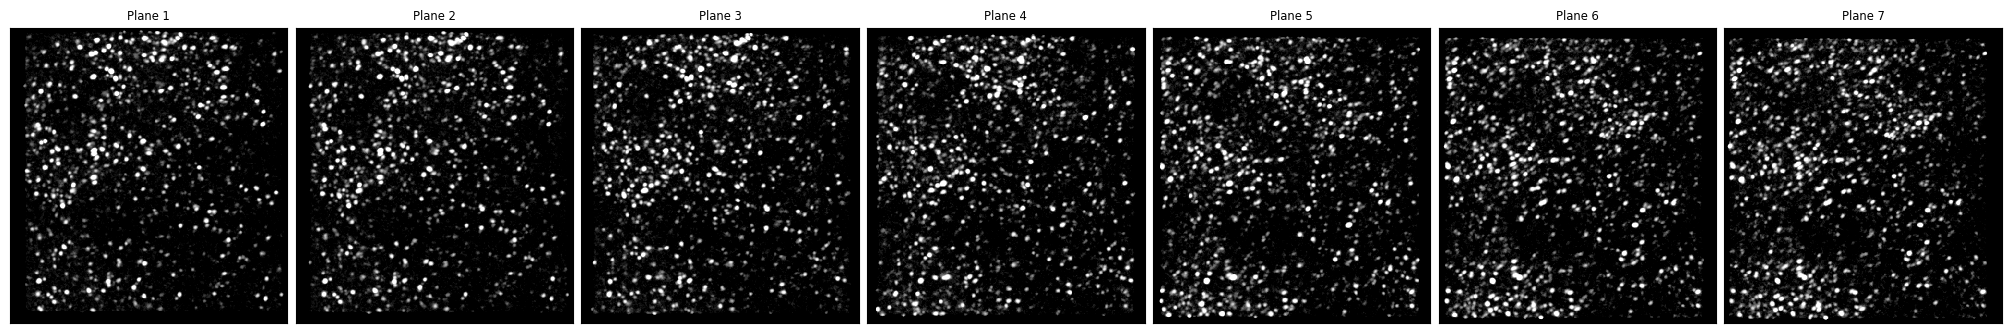

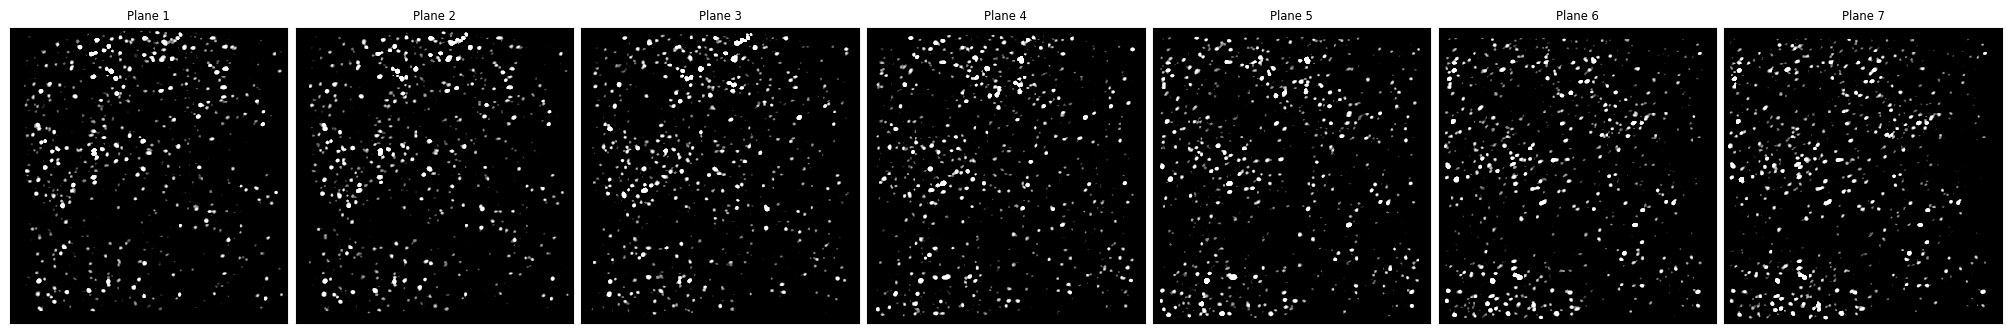

In [72]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5), vminmax_percentile=(50,99))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax_percentile=(50,99))

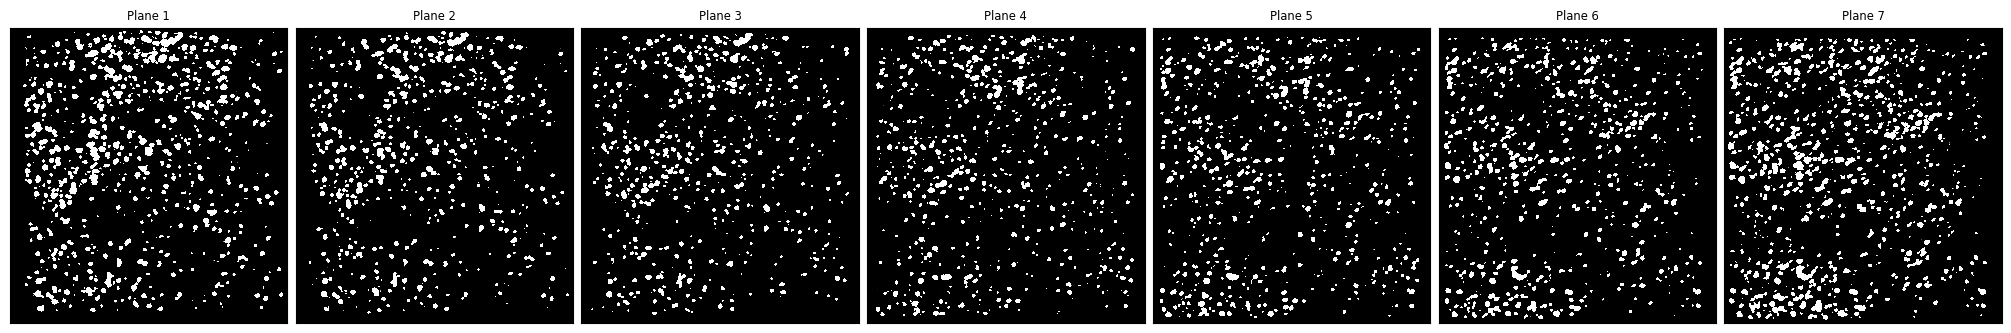

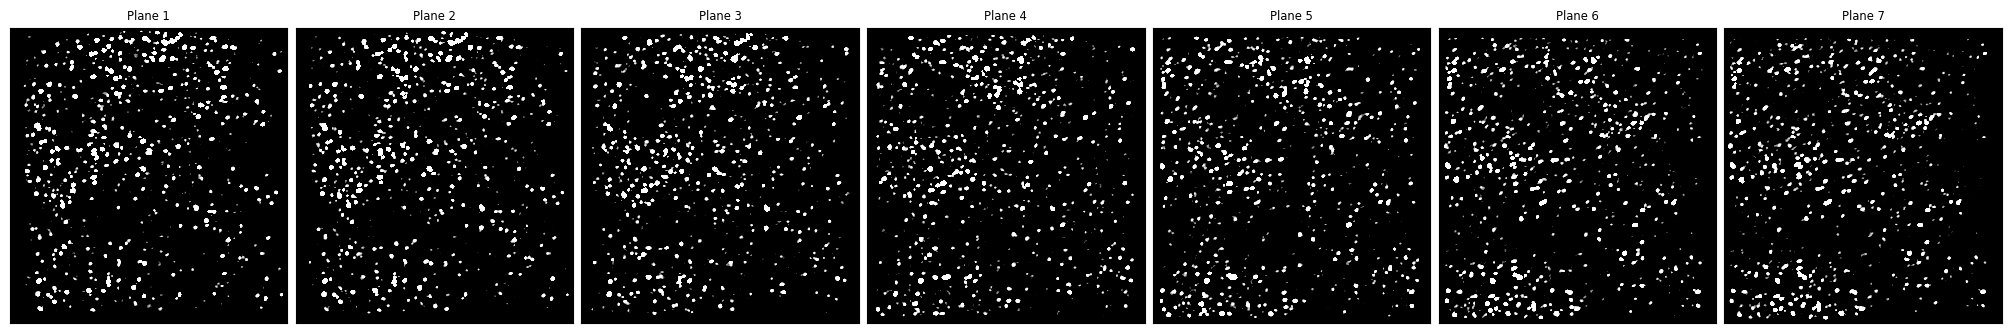

In [74]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5), vminmax=(0.25,0.251))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax=(0.00,1e-1))

In [ ]:
tfu.show_tif_all_planes(corr_map, ncols=7, figsize=(20,5), vminmax_percentile=(50,99.9))
tfu.show_tif_all_planes(corr_map_thresh, ncols=7, figsize=(20,5), vminmax_percentile=(50,99))

(120, 120)

In [116]:
mov.shape

(7, 2000, 616, 579)

In [117]:
%%time
job.params['peak_thresh'] = 0.02
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1 

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (250, 250)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh)

      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation and /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 9
      Found dir /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/segmentation/patch-0000
         Loading 3.26 GB movie to memory, shape: (2000, 7, 250, 250) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.020 and Th2: 5.000
         Iter 0000: running 64 ROIs in parallel
         Added cell 1 at 00, 040, 205, peak: 1.044, thresh: 5.000, 396 frames,

'/mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois'

In [118]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')#, additional_info = job.load_corr_map_results())

   Updated main params file
   Movie shape: (7, 2000, 616, 579)
7925
   Extracting 7925 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 4 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
            Extracting batch 0000 of 0004
            Batch size: 4 GB
            Extracting batch 0001 of 0004
            Batch size: 4 GB
            Extracting batch 0002 of 0004
            Batch size: 4 GB
            Extracting batch 0003 of 0004
            Batch size: 4 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois
   Created dir /mnt/zeytin-f1/s3d-results/s3d-results-SS003_2024-08-16_1-2-3-4subset to export results
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/stats_small.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-16_1-2-3-4subset/rois/info.npy
      Lo

In [119]:
reg = job.load_registration_results()

In [120]:
shifts = n.concatenate(reg['int_shift'],axis=0)
sp_shifts = n.concatenate(reg['sub_pixel_shifts'], axis=0)

(0.0, 100.0)

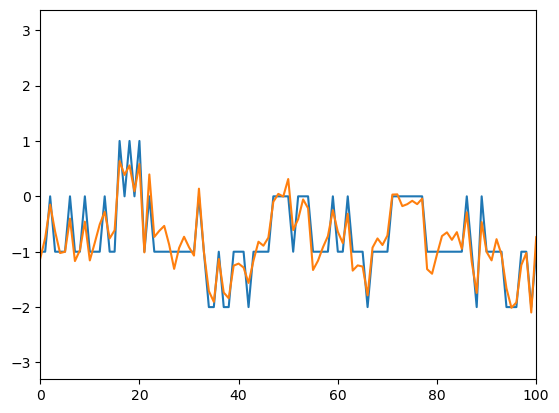

In [121]:
plt.plot(shifts[:,2])
plt.plot(sp_shifts[:,2])
plt.xlim(0,100)

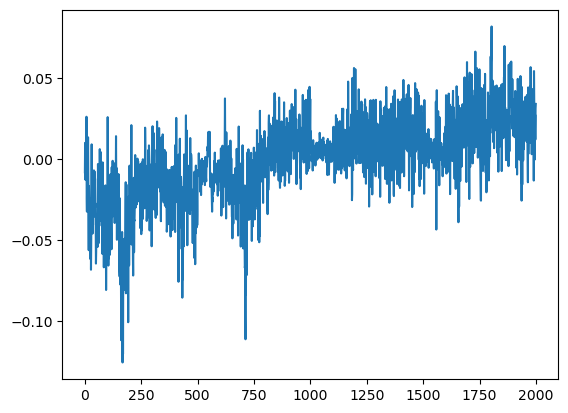

In [122]:
plt.plot(sp_shifts[:,0])